## Brazilian flight delays

As an enthuasiast for getting insights from real world data, I was delighted to see that ANAC (Brazil's FAA equivalent) makes all flight data available on its website. To use it, we'll have to do some web scraping to download information spanning from 2008 to 2019 (which adds up to more than 100 files). 

It doesn't take a lot of digging to get interesting finds. For instance, we can see straight away a significant increase in the number of Brazilian flights from 2008 (which matched the country's economic boom in the 2010's) but then a decrease from 2013, especially for international routes.



I was also excited to see how many delays happen for the flight route I take the most (São Paulo - Belo Horizonte), as well as which carrier takes the prize for the least timely flights. We'll also use Facebook Prophet to analyse seasonality and growth trends on Brazil's flight routes, and see if we can predict the total number of flights in the future.

Overall, I am glad that open data policies exist. Aggregated, real world data is hard to come by - especially the kind I can use to improve my flight choices and reduce the amount of time I spend waiting around at airports.

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines
from matplotlib.lines import Line2D
import requests
import urllib.request
import time
import matplotlib.ticker as ticker
from bs4 import BeautifulSoup
import re
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import zipfile
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import dask.dataframe as dd
import gc
import datetime
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from fbprophet import Prophet
from pandas.tseries import converter
converter.register()
from sklearn.metrics import mean_absolute_error as MAE
;

C:\Users\A0071306\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
C:\Users\A0071306\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 


''

## Web scraping (+ some use for Regex)

We're going to use web scraping for downloading all files at once from ANAC's website. 

Here I use regex for identifying the right files and creating a list with the URLs. I also set the year range from 2008 to 2019.

In [3]:
#Downloading all links starting from 2008. Credits for part of this code go to TowardsDataScience.com (Julia Kho's article)
def getLinks(url):
    response = requests.get(url,verify=False)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for year in range(2008, 2020):
        for link in soup.findAll('a', string = True, attrs={'href': re.compile(f"https:\/\/www.anac.gov.br\/assuntos\/dados-e-estatisticas\/(?:.*)({year})\/(?:.*)(csv|zip|xlsx|xls)")}):
            links.append(link.get('href'))
    return links

#Inserting flight data URL and getting a list
links = getLinks('https://www.anac.gov.br/assuntos/dados-e-estatisticas/historico-de-voos')

Now we'll download all URLs in our list to our local folder:

In [4]:
#Downloading URLs in our list. Credits for this script go to QuickProgrammingTips.com
import requests
from multiprocessing.pool import ThreadPool
 
def download_url(url):
  # assumes that the last segment after the / represents the file name
  # if url is abc/xyz/file.txt, the file name will be file.txt
  file_name_start_pos = url.rfind("/") + 1
  file_name = re.sub(r"[-()\"#/@;:<>{}`+=~^|!?,]", "", url[file_name_start_pos:])
  r = requests.get(url, stream=True, verify = False)
  if r.status_code == requests.codes.ok:
    with open(file_name, 'wb') as f:
      for data in r:
        f.write(data)
  return url
 
# Run 5 multiple threads. Each call will take the next element in urls list
results = ThreadPool(5).imap_unordered(download_url, links)
    
time.sleep(1);

#### Extracting all zip files

Some of the files which we downloaded are zipped. Therefore, we'll have to extract them to our local folder

In [30]:
import os, zipfile, sys

dir_name = sys.path[0]
extension = ".zip"

os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file


## Merging all files in our directory

We'll read and merge all of the CSV files in our directory - which were either downloaded directly from ANAC's website or extracted to our local folder.  

#### Importing and merging CSV files 

In [3]:
import glob
import os

#Setting column names before we merge our files
colnames = ['AIRLINE', 'FLIGHT_NO', 'DI_CODE', 
            'FLIGHT_TYPE', 'AIRPORT_ORIGIN', 'AIRPORT_DEST', 
            'EXP_DEPARTURE', 'ACTUAL_DEPARTURE', 'EXP_ARRIVAL', 
            'ACTUAL_ARRIVAL', 'FLIGHT_STATUS', 'DELAY_REASON']

colnames_dec17 = ['AIRLINE', 'FLIGHT_NO', 'DI_CODE', 
                  'FLIGHT_TYPE', 'AIRPORT_ORIGIN', 'AIRPORT_DEST', 
                  'EXP_DEPARTURE', 'DEPARTURE_DATE', 'ACTUAL_DEPARTURE', 
                  'EXP_ARRIVAL', 'ACTUAL_ARRIVAL', 'FLIGHT_STATUS', 'DELAY_REASON']


#Opening and concatenating all csv files in our directory. 
df_csv=pd.DataFrame()
for files in glob.glob("*.csv"):
    #Importing all csv files except the dec/17 one
    if files == 'VRA12_2017.csv': continue 
    df_csv = pd.concat([df_csv,
                        pd.read_csv(open(files, 'r', encoding = 'ISO-8859-1'), 
                                    skiprows = 1, names = colnames,  
                                    encoding = "ISO-8859-1", 
                                    dayfirst=True, parse_dates=True, 
                                    #We don't specify any separators so python automatically guesses which one it is for each CSV file.
                                    sep = None, engine = 'python')])

#Importing the dec/17 file separately, as it has one more column than the other files
df_csv = pd.concat([df_csv,
                        pd.read_csv('VRA12_2017.csv', 
                                    skiprows = 1, names = colnames_dec17,
                                    usecols = colnames,
                                    encoding = "ISO-8859-1", 
                                    dayfirst=True, parse_dates=True, 
                                    #We don't specify any separators so python automatically guesses which one it is for each CSV file.
                                    sep = None, engine = 'python')])

#Converting empty rows to NaN
df_csv = df_csv.replace(r'^\s*$', 
                        np.nan, regex=True)
    
#Selecting columns we want to clean
for i in ['EXP_DEPARTURE', 'ACTUAL_DEPARTURE', 'EXP_ARRIVAL', 'ACTUAL_ARRIVAL']:   
    #Removing string values which were not skipped when reading the csv file
    df_csv = (df_csv[~(df_csv[i]
                     .astype(str)
                     .str.contains('Prevista|Real'))])
    #Converting date columns to the date64 format
    df_csv[i] = pd.to_datetime(df_csv[i], 
                               format = "%d/%m/%Y %H:%M", errors = 'coerce');

#### Importing, merging and cleaning xlsx files 

Some of the files we downloaded were in the MS Excel format. We'll merge all of them so that we can later integrate with the rest of our dataset.

In [4]:
#Setting column names before we merge our files
colnames = ['AIRLINE', 'FLIGHT_NO', 'DI_CODE', 
            'FLIGHT_TYPE', 'AIRPORT_ORIGIN', 'AIRPORT_DEST',
            'EXP_DEPARTURE', 'ACTUAL_DEPARTURE', 'EXP_ARRIVAL', 
            'ACTUAL_ARRIVAL', 'FLIGHT_STATUS', 'DELAY_REASON']

#Creating empty df (df_xlsx) and putting all .xlsx files from our directory in it 
df_xlsx = pd.DataFrame()
import glob
for excel in glob.glob("*.xlsx"):
    df_xlsx = pd.concat([df_xlsx, 
                         pd.read_excel(excel, encoding = 'ISO-8859-1', skiprows = 1, names = colnames)])

#Converting empty rows to NaN
df_xlsx = df_xlsx.replace(r'^\s*$', 
                        np.nan, regex=True)
    
#Selecting columns we want to clean
for i in ['EXP_DEPARTURE', 'ACTUAL_DEPARTURE', 'EXP_ARRIVAL', 'ACTUAL_ARRIVAL']:
    #Removing string values which were not skipped when reading the csv file
    df_xlsx = df_xlsx[~(df_xlsx[i].astype(str).str.contains('Prevista|Real'))]
    #Converting date columns to the date64 format
    df_xlsx[i] = pd.to_datetime(df_xlsx[i].astype(str), 
                                format='%Y-%m-%d %H:%M', errors = 'coerce')

#### Merging dataframes from CSV and XLSX files

In [5]:
#Merging dataframes originated from csv and xlsx files given the operations above
flight_data = pd.concat([df_csv, df_xlsx], sort = False)

#### Data Cleaning 

Let's reset the dataframe's index after we've merged our files. We'll also replace flights classified as either R, H, E with the 'N' (national) tag since those could also be considered regular domestic flights. This will ensure consistency when analysing the total number of national flights across the years.  

In [6]:
#Resetting index
flight_data = flight_data.reset_index(drop=True)

#Replacing regional with national tags. This is due to inconsistent flight type tagging.
flight_data['FLIGHT_TYPE'] = flight_data['FLIGHT_TYPE'].replace({'R':'N', 'H':'N', 'E':'N'})

#Filtering out flights which happened before jan/2008
for i in ['EXP_DEPARTURE', 'EXP_ARRIVAL']:
    flight_data = flight_data[flight_data[i].dt.to_period('M') > '2007-12']

## Calculating delays and % of cancelled flights 

Now that we have a clean dataset, let's calculate delays using the difference between expected and actual departure/arrivals.
We'll also create flags for delayed and cancelled flights. We'll consider all flights which departed/arrived 15 minutes later than scheduled to be delayed.  

In [15]:
#Flagging flights w/delayed departure
flight_data['DELAYED_DEPARTURE'] = np.where(flight_data['ACTUAL_DEPARTURE'] > 
                                            (flight_data['EXP_DEPARTURE'] + pd.Timedelta(minutes = 15)),
                                            1, 0)
#Flagging flights w/delayed arrival
flight_data['DELAYED_ARRIVAL'] = np.where(flight_data['ACTUAL_ARRIVAL'] > 
                                          (flight_data['EXP_ARRIVAL'] + pd.Timedelta(minutes = 15)), 
                                          1, 0)
#Flagging cancelled flights
flight_data['CANCELLED_FLIGHT'] = np.where(flight_data['FLIGHT_STATUS'].isin(['CANCELADO', 'Cancelado']),
                                           1, 0)

#Calculating time difference between expected departure and actual departure in minutes
flight_data['DEPARTURE_DIFFERENCE_MIN'] = (flight_data['ACTUAL_DEPARTURE'].subtract(flight_data['EXP_DEPARTURE']))
flight_data['DEPARTURE_DIFFERENCE_MIN'] = flight_data['DEPARTURE_DIFFERENCE_MIN'].dt.total_seconds() / 60

#Calculating time difference between expected arrival and actual arrival in minutes
flight_data['ARRIVAL_DIFFERENCE_MIN'] = (flight_data['ACTUAL_ARRIVAL'] - 
                                         flight_data['EXP_ARRIVAL'])
flight_data['ARRIVAL_DIFFERENCE_MIN'] = flight_data['ARRIVAL_DIFFERENCE_MIN'].dt.total_seconds() / 60

#Creating new column with the arrival month
flight_data['ARRIVAL_MONTH'] = (flight_data['ACTUAL_ARRIVAL'].dt.to_period('M'))
flight_data['ARRIVAL_MONTH'] = flight_data['ARRIVAL_MONTH'].dt.to_timestamp() 

Finally, let's filter out outliers (flights occurring during the world cup were not available, let's remove anything in those dates)

In [ ]:
#Resetting index
flight_data = flight_data.reset_index(drop = True)

for i in ['EXP_DEPARTURE', 'EXP_ARRIVAL', 'ACTUAL_DEPARTURE', 'ACTUAL_ARRIVAL']:
#Excluding jun/14 and jul/14 months from our dataset
    flight_data = flight_data[~((flight_data[i].dt.to_period('M') == '2014-06') |
                               (flight_data[i].dt.to_period('M') == '2014-07'))]

for i in ['EXP_DEPARTURE', 'EXP_ARRIVAL']:
    #We'll only look at flights which took place in August, or before. That way, my conclusions here will be the same as when you download the flight datafiles. 
    flight_data = flight_data[(flight_data[i] < '2019-09')] 

ANAC's dataset was pretty clean from the get go, which is a rare thing for most data you encounter in the real world. That was a pleasant surprise.

#### Saving our final file to HDF (faster writing than CSV)

## Analyzing flight data


#### Importing flight data from our previously saved hdf file

In [3]:
flight_data = pd.read_hdf('FLIGHT_DATA.hd5', key = 'FLIGHT_DATA')

### Summarizing total number of flights in and out of brazilian airports per month (natl' and intl' flights)

A good overview of our dataset would be to count all flights for each month, and separate them by flight type. We'll also group all flights by carrier, so that we can see which are the companies with most routes throughout the years.   

In [3]:
#Selecting only commercial flights
flight_data = flight_data[flight_data['FLIGHT_TYPE'].isin(['N', 'I'])]

In [4]:
#Counting the total number of international and national flights by month
total_flights = (flight_data
                .groupby(['ARRIVAL_MONTH','FLIGHT_TYPE'])
                 ['FLIGHT_NO']
                .agg('count')
                .reset_index()
                .rename(columns = {'FLIGHT_NO':'NUM_FLIGHTS'}))

#Rebasing the total number flights to 100, so we can see the % evolution of national and intl' flights since 2008
total_flights['NUM_FLIGHTS_100'] =  (total_flights['NUM_FLIGHTS'] / 
                                     total_flights.groupby('FLIGHT_TYPE')['NUM_FLIGHTS'].transform('first'))

#Counting the total number of flights per airline
total_flights_airline = (flight_data
               .groupby(['ARRIVAL_MONTH', 'AIRLINE', 'FLIGHT_TYPE'])
                    ['FLIGHT_NO']
               .agg('count')
               .reset_index()
               .rename(columns = {'FLIGHT_NO':'NUM_FLIGHTS'}))

### Selecting top 4 airlines in the year of 2018

Since we can't plot all airlines on the same graph, we'll choose the 4 biggest for national and international routes. 

In [8]:
#Grouping by airline and filtering for the year of 2018
total_flights_airline_2018 = (total_flights_airline[
                              total_flights_airline['ARRIVAL_MONTH'].dt.to_period('Y') == 2018]
                             .groupby(['AIRLINE', 'FLIGHT_TYPE'])['NUM_FLIGHTS']
                             .agg('sum')
                             .reset_index())

#Selecting top airlines for natl' and intl' flights. Credit for this snippet goes to cmdlinetips.com 
top_airlines = (total_flights_airline_2018
                .groupby(['FLIGHT_TYPE'])
                .apply(lambda x: x.sort_values(['NUM_FLIGHTS'], ascending = False))
                .reset_index(drop=True)
                .groupby('FLIGHT_TYPE')
                .head(4)
                [['AIRLINE', 'FLIGHT_TYPE']])

#Filtering for top airlines so we can plot them on a graph.
top_airlines = pd.merge(top_airlines, total_flights_airline, how = 'left')

#Filtering for arrival month
top_airlines = top_airlines[
            (top_airlines['ARRIVAL_MONTH'] > '2007-12-01') &
            (top_airlines['ARRIVAL_MONTH'] < '2019-09-01')]

## Graphing the total number of flights in Brazil

Let's plot the total number of flights by month and see if we can find something. 

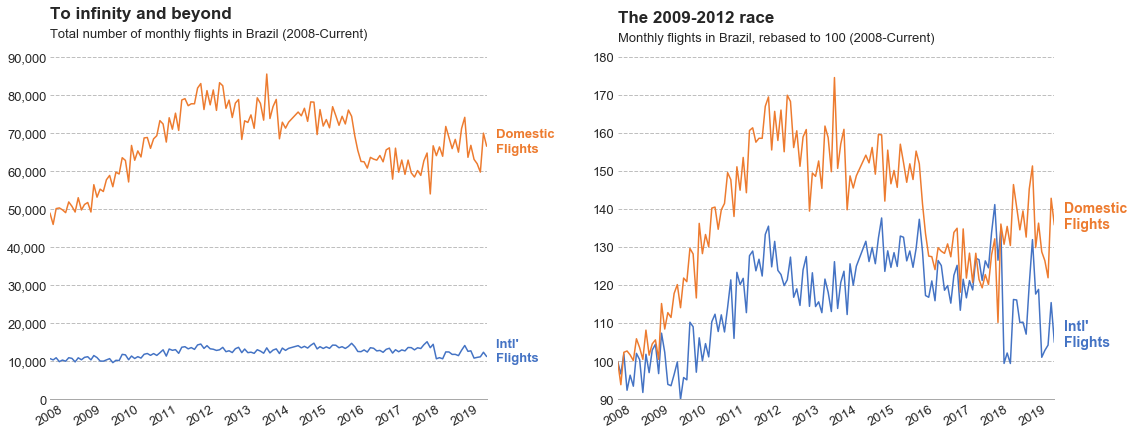

In [9]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(1,2)

#Setting line colors
color_flights = {'N':'#ed7b2f', 'I':'#4473c4'}

for l, g in total_flights.groupby(['FLIGHT_TYPE']):
    g.plot(x = 'ARRIVAL_MONTH', y = 'NUM_FLIGHTS', label= l, ax = ax[0], linewidth = 1.5, color = color_flights[l])
for l, g in total_flights.groupby(['FLIGHT_TYPE']):
    g.plot(x = 'ARRIVAL_MONTH', y = 'NUM_FLIGHTS_100', label= l, ax = ax[1], linewidth = 1.5, color = color_flights[l])    
    
#Formatting common proprieties among axes      
for i in itertools.product(np.arange(0,2)):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_linewidth(1)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['bottom'].set_color('#A9A9A9')
    ax[i].set(xlabel = '')
    ax[i].yaxis.grid(linestyle = '--', alpha=0.55)
    ax[i].set_facecolor('white')
    ax[i].yaxis.grid(linestyle = '--', alpha=0.5, color = 'grey')
    ax[i].tick_params(axis="y", labelsize=13)
    ax[i].xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax[i].get_xticklabels(minor=False), rotation = 30, ha="center", fontsize = 13)
    ax[i].set_facecolor('#ffffff')
    ax[i].get_legend().remove()
    formatter = DateFormatter('%Y')
    ax[i].xaxis.set_major_formatter(formatter)

#FIRST QUADRANT
#Setting y axis format
ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
#Setting ylim
ax[0].set_ylim([0,90000])
ax[0].set_yticks(np.arange(0,100000,10000))

#Setting text
ax[0].text(s='To infinity and beyond', x = '2008-01-01', y = 100000, fontsize = 17, weight = 'bold')
ax[0].text(s='Total number of monthly flights in Brazil (2008-Current)' , x = '2008-01-01', y = 95000, fontsize = 13)
ax[0].text(s='''Domestic 
Flights''' , x = '2019-11-01', y = 65000, fontsize = 13, color = '#ed7b2f', weight = 'bold')
ax[0].text(s='''Intl' 
Flights''' , x = '2019-11-01', y = 10000, fontsize = 13, color = '#4473c4', weight = 'bold')

#SECOND QUADRANT
#Setting y axis format
ax[1].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y*100)))

#Setting ylim
ax[i].set_ylim([0.9,1.8])
ax[i].set_yticks(np.arange(0.9,1.9,0.1))

#Setting text
ax[1].text(s='The 2009-2012 race', x = '2008-01-01', y = 1.89, fontsize = 17, weight = 'bold')
ax[1].text(s='Monthly flights in Brazil, rebased to 100 (2008-Current)' , x = '2008-01-01', y = 1.84, fontsize = 13)
ax[1].text(s='''Domestic 
Flights''' , x = '2019-11-01', y = 1.35, fontsize = 14, color = '#ed7b2f', weight = 'bold')
ax[1].text(s='''Intl' 
Flights''' , x = '2019-11-01', y = 1.04, fontsize = 14, color = '#4473c4', weight = 'bold')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(18, 7)
plt.savefig('GRAFICO_VOOS.jpg', dpi=400, bbox_inches='tight', facecolor=fig.get_facecolor())

Brazil experienced a sharp growth on its airline sector from 2009, especially with its domestic routes: already in 2012, there were 70% more monthly domestic flights compared to 2008. However, that number dropped sharply from 2012, and as of today stands at around 40%.

International routes also expanded by 30% between 2008-2012 but then they began dropping: in the end of 2017, the number of monthly flights was the same as in a decade ago. In 2018 there was a recovery, followed by a sharp fall in 2019 - leaving us today with 10% more flights than in 2008. 

## Graphing the total number of flights by airline in Brazil

Let's now see the total number of flights for the top 4 domestic and international carriers in the year 2018. 

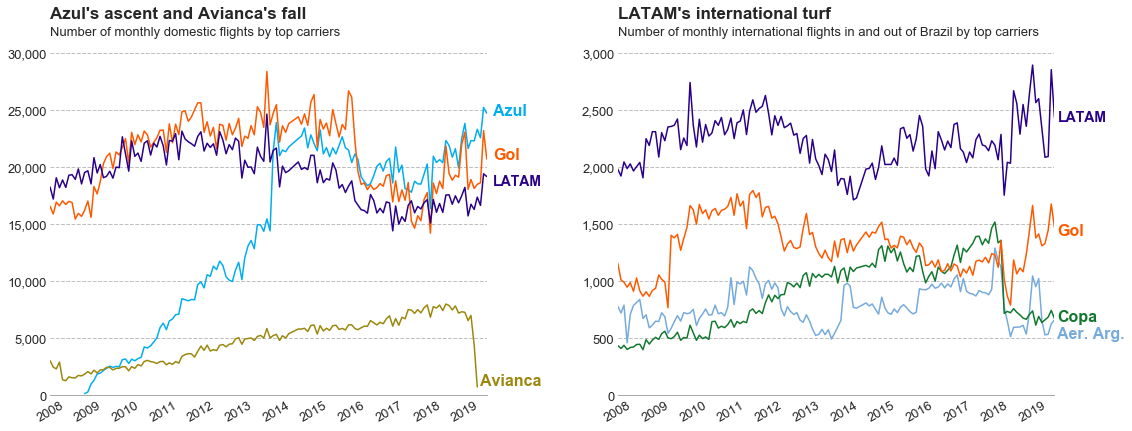

In [10]:
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(1,2)

#Setting line colors
color_carriers_N = {'AZU':'#00adef', 'GLO':'#ff5900', 'TAM':'#290088' , 'ONE':'#9b870c'}
color_carriers_I = {'TAM':'#290088', 'GLO':'#ff5900', 'CMP':'#11772D' , 'ARG':'#75AADB'}

for l, g in top_airlines[top_airlines['FLIGHT_TYPE'] == 'N'].groupby(['AIRLINE', 'FLIGHT_TYPE']):
    g.plot(x = 'ARRIVAL_MONTH', y = 'NUM_FLIGHTS', label= l, ax = ax[0], linewidth = 1.5, color=color_carriers_N[l[0]])
for l, g in top_airlines[top_airlines['FLIGHT_TYPE'] == 'I'].groupby(['AIRLINE', 'FLIGHT_TYPE']):
    g.plot(x = 'ARRIVAL_MONTH', y = 'NUM_FLIGHTS', label= l, ax = ax[1], linewidth = 1.5, color=color_carriers_I[l[0]])
    
#Formatting common proprieties among axes      
for i in np.arange(0,2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_linewidth(1)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['bottom'].set_color('#A9A9A9')
    ax[i].set(xlabel = '')
    ax[i].yaxis.grid(linestyle = '--', alpha=0.55)
    ax[i].set_facecolor('white')
    ax[i].yaxis.grid(linestyle = '--', alpha=0.5, color = 'grey')
    ax[i].tick_params(axis="y", labelsize=13)
    ax[i].xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax[i].get_xticklabels(minor=False), rotation = 30, ha="center", fontsize = 13)
    formatter = DateFormatter('%Y')
    ax[i].xaxis.set_major_formatter(formatter)
    ax[i].set_facecolor('#ffffff')
    ax[i].get_legend().remove()
    ax[i].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))

    
#FIRST QUADRANT
#Setting ylim
ax[0].set_ylim([0,30000])
ax[0].set_yticks(np.arange(0,35000,5000))
#Setting title
ax[0].text(s='''Azul's ascent and Avianca's fall''', x = '2008-01-01', y = 33000, fontsize = 17, weight = 'bold')
ax[0].text(s='Number of monthly domestic flights by top carriers' , x = '2008-01-01', y = 31500, fontsize = 13)
#Carriers
ax[0].text(s='''Azul''' , x = '2019-09-30', y = 24500, fontsize = 16, color = '#00adef', weight = 'bold')
ax[0].text(s='''Gol''' , x = '2019-09-30', y = 20700, fontsize = 16, color = '#ff5900', weight = 'bold')
ax[0].text(s='''LATAM''' , x = '2019-09-30', y = 18400, fontsize = 14, color = '#290088', weight = 'bold')
ax[0].text(s='''Avianca''' , x = '2019-06-01', y = 900, fontsize = 16, color = '#9b870c', weight = 'bold')


#SECOND QUADRANT
#Setting ylim
ax[1].set_ylim([0,3000])
ax[1].set_yticks(np.arange(0,3500,500))
#Setting title
ax[1].text(s='''LATAM's international turf''', x = '2008-01-01', y = 3300, fontsize = 17, weight = 'bold')
ax[1].text(s='Number of monthly international flights in and out of Brazil by top carriers' , x = '2008-01-01', y = 3150, fontsize = 13)
#Carriers
ax[1].text(s='''LATAM''' , x = '2019-08-30', y = 2400, fontsize = 14, color = '#290088', weight = 'bold')
ax[1].text(s='''Gol''' , x = '2019-08-30', y = 1400, fontsize = 16, color = '#ff5900', weight = 'bold')
ax[1].text(s='''Copa''' , x = '2019-08-30', y = 650, fontsize = 16, color = '#11772D', weight = 'bold')
ax[1].text(s='''Aer. Arg.''' , x = '2019-08-30', y = 500, fontsize = 16, color = '#75AADB', weight = 'bold')

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(18, 7)
plt.savefig('GRAFICO_VOOS.jpg', dpi=400, bbox_inches='tight', facecolor=fig.get_facecolor())

Right off the bat, we can see Azul's rise from being a carrier which didn't exist in 2008 to becoming one of the top airlines for domestic flights already in 2014. We also notice Avianca's abrupt fall given the company's bankruptcy filings in the beginning of 2019.   

In the international routes market, LATAM leads the way with the highest number of monthly routes - its position has been unmatched throughout the decade. In the beginning of 2009, Gol experienced a 50% increase in its own international routes. Ever since, it seems to hover around 1,500 monthly international flights, lagging far behind LATAM. 

Copa Airlines had a three-fold increase in its international flight routes from 2008 until the end of 2017. However, in the beginning of 2018 it seems to have slashed its international routes in and out of Brazil by a third, and it now alternates positions with Aerolineas Argentinas.

## Calculating flight concentration on main airports with a Pareto Chart

Given the sharp increase in flights from 2008, are they now distributed across a greater number of airports? 
We can check that out by plotting a Pareto Chart.

In [9]:
#Counting total number of flights per airport of origin, flight type, and year 
flight_dist = (flight_data
                       .groupby([flight_data['ACTUAL_DEPARTURE'].dt.year, 
                                 'AIRPORT_ORIGIN', 
                                 'FLIGHT_TYPE'])
                       ['AIRLINE']
                       .agg('count')
                       .reset_index()
                       .rename(columns = {'AIRPORT_ORIGIN':'AIRPORT',
                                         'AIRLINE':'NO_FLIGHTS'}))


#Creating a new column indicating whether the count corresponds to the number of inbound or outbound flights
flight_dist['FLIGHT_DIRECTION'] = 'OUTBOUND'

#Selecting international and domestic flights only 
flight_dist = flight_dist[flight_dist['FLIGHT_TYPE'].isin(['N', 'I'])]

Now that we have the total number of flights per airport, let's calculate the cumulative distribution

In [10]:
#Calculating how much each airport represents in terms of total number of flights
flight_dist['PERCENT_GROUP'] = flight_dist['NO_FLIGHTS'] / (flight_dist
                                                            .groupby(['ACTUAL_DEPARTURE', 'FLIGHT_TYPE', 'FLIGHT_DIRECTION'])
                                                            ['NO_FLIGHTS']
                                                            .transform('sum'))

#Sorting values so that we can apply a cumulative sum on busiest airports first
flight_dist = (flight_dist
               .sort_values(['ACTUAL_DEPARTURE', 'FLIGHT_TYPE', 
                             'FLIGHT_DIRECTION', 'PERCENT_GROUP'], ascending = False))

#Creating cumulative sum of the total flight number by direction, departure year, airport and flight type
flight_dist['CUM_SUM_TOTAL'] = (flight_dist
                                .groupby(['ACTUAL_DEPARTURE', 'FLIGHT_TYPE', 'FLIGHT_DIRECTION'])['NO_FLIGHTS']
                                .cumsum())

flight_dist['CUM_SUM_PERCENT'] = (flight_dist
                                .groupby(['ACTUAL_DEPARTURE', 'FLIGHT_TYPE', 'FLIGHT_DIRECTION'])['PERCENT_GROUP']
                                  .cumsum())

#Creating cumulative count (% count versus total number of airports)
flight_dist['FREQUENCY'] = 1
flight_dist['AIRPORT_COUNT'] = (flight_dist
                            .groupby(['ACTUAL_DEPARTURE', 'FLIGHT_TYPE', 'FLIGHT_DIRECTION'])['FREQUENCY']
                            .cumsum())

#Calculating how much the the cumulative frequency represents of the total number of airports
flight_dist['PERCENT_AIRPORTS'] = flight_dist['AIRPORT_COUNT'] / (flight_dist
                                                            .groupby(['ACTUAL_DEPARTURE', 'FLIGHT_TYPE', 'FLIGHT_DIRECTION'])
                                                            ['AIRPORT_COUNT']
                                                            .transform('sum'))
flight_dist['CUM_SUM_%_AIRPORT'] = (flight_dist
                                .groupby(['ACTUAL_DEPARTURE', 'FLIGHT_TYPE', 'FLIGHT_DIRECTION'])['PERCENT_AIRPORTS']
                                  .cumsum())


#Selecting the years of 2008 and 2018
flight_dist = flight_dist[flight_dist['ACTUAL_DEPARTURE'].isin([2008, 2018])]

Graphing cumulative distributions (for national and international flights)

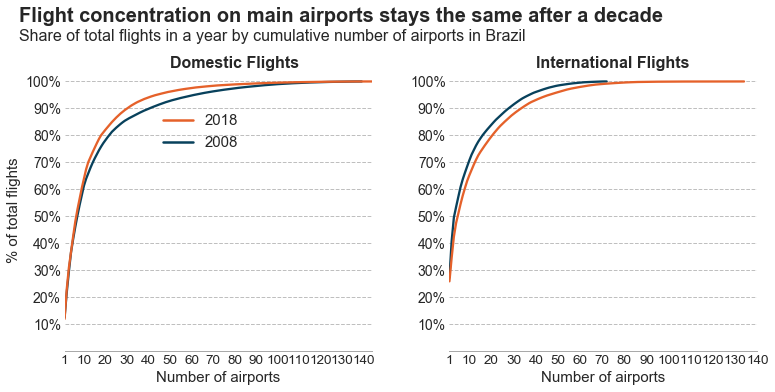

<Figure size 1800x1200 with 0 Axes>

In [16]:
FLIGHT_DIRECTIONS = ['OUTBOUND']
FLIGHT_TYPES = ['N', 'I']

plt.style.use('seaborn-dark')
fig, ax = plt.subplots(1,2)
for i, flight_direction in enumerate(FLIGHT_DIRECTIONS):
    for j, flight_type in enumerate(FLIGHT_TYPES):
        for l, g in (flight_dist[(flight_dist['FLIGHT_DIRECTION'] == flight_direction) & 
                             (flight_dist['FLIGHT_TYPE'] == flight_type)].groupby('ACTUAL_DEPARTURE')):
            g.plot(x='AIRPORT_COUNT', label=l, y='CUM_SUM_PERCENT', ax=ax[j], figsize=(10, 6), linewidth = 2.3, linestyle = '-')
            
for i in np.arange(0,2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set(xlabel = 'Number of airports')
    ax[i].get_legend().remove()
    ax[i].tick_params(axis="y", labelsize=14)
    ax[i].tick_params(axis="x", labelsize=13.5)
    ax[i].yaxis.grid(linestyle = '--', alpha=0.55)
    ax[i].set_facecolor('white')
    ax[i].yaxis.grid(linestyle = '--', alpha=0.5, color = 'grey')
    ax[i].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, _: '{0:.0f}%'.format(y*100).replace('.', ',')))
    ax[i].spines['bottom'].set_linewidth(1)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['bottom'].set_color('#A9A9A9')
    ax[i].set_ylim([0,1.05])
    ax[i].set_yticks(np.arange(0.1,1.1,0.1))
    ax[i].set_xticks(np.insert(np.arange(20,150,10),1, [1,10]))
    ax[i].set_xlabel('Number of airports', size = 15)
    ax[i].set_ylabel('', size = 15)
    ax[i].get_lines()[0].set_color("#08415C")
    ax[i].get_lines()[1].set_color("#e5612a")

    
ax[0].text(s='''Flight concentration on main airports stays the same after a decade''' , x = -20, y = 1.22, fontsize = 20, weight = 'bold')
ax[0].text(s='''Share of total flights in a year by cumulative number of airports in Brazil''', x = -20, y = 1.15, fontsize = 16)
ax[0].text(s='Domestic Flights', fontsize = 16, weight = 'bold', x = 50, y = 1.05)
ax[1].text(s='International Flights', fontsize = 16, weight = 'bold', x = 40, y = 1.05)    

legend_elements = [Line2D([0], [0], color='#e5612a', lw=2.5, label='2018'),
                   Line2D([0], [0], color='#08415C', lw=2.5, label='2008')]
ax[0].legend(handles=legend_elements, prop={'size': 15}, loc = (0.3,0.69))
ax[0].set_ylabel('% of total flights', size = 15)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.set_size_inches(11, 5.5)
plt.figure(dpi=300);

Roughly 80% of all outbound flights take place in 20 airports (out of 140), showing just how concentrated the Brazilian airline market is. In a decade, we have even fewer airports carrying the bulk domestic flights. 

International flights seem to have spread out in a decade, but the curve is roughly the same for the 5 main brazilian airports - redistribution therefore took place at smaller airports. Furthermore, we have one single airport (Guarulhos) still carrying a third of international flights out of Brazil.

## Identifying Congonhas' busiest routes

Let's see the main routes on a Friday night out of Congonhas and also the % of delays each departing hour. I suspect that things get chaotic from 17h, given the number of people getting off work and returning to their hometown for the weekend. 

In [272]:
#Selecting top routes out of Congonhas' airport in 2018
top_CGH_routes = (flight_data[(flight_data['AIRPORT_ORIGIN'] == 'SBSP')
                  & (flight_data['EXP_DEPARTURE'].dt.to_period('Y') == 2018)]
                  .groupby(['AIRPORT_DEST', 'FLIGHT_TYPE'])
                  ['FLIGHT_NO']
                  .agg('count')
                  .reset_index()
                  .rename(columns = {'FLIGHT_NO':'NUM_FLIGHTS'})
                  .sort_values('NUM_FLIGHTS', ascending = False)
                  .head(3)
                  ['AIRPORT_DEST'])

#Filtering only top routes from CGH
top_CGH_routes = pd.merge(top_CGH_routes, 
                          flight_data[(flight_data['AIRPORT_ORIGIN'] == 'SBSP')], 
                          how = 'left')

#Dissecting dates so we can better analyse them
top_CGH_routes['YEAR'] = top_CGH_routes['EXP_DEPARTURE'].dt.year
top_CGH_routes['WEEK'] = top_CGH_routes['EXP_DEPARTURE'].dt.week
top_CGH_routes['DAY'] = top_CGH_routes['EXP_DEPARTURE'].dt.dayofweek
top_CGH_routes['HOUR'] = top_CGH_routes['EXP_DEPARTURE'].dt.hour

#### Mean delay rate for flights leaving Congonhas in the year so far

In [273]:
#Calculating % of delays 
CGH_routes_hist = (top_CGH_routes[
                    (top_CGH_routes['ARRIVAL_MONTH'] > '2019-01-01') &
                    (top_CGH_routes['DAY'] == 4)]
                   .groupby(['AIRLINE', 'HOUR', 'AIRPORT_DEST'])
                    ['DELAYED_ARRIVAL']
                   .agg(['count', 'mean', 'sum'])
                   .reset_index())

#Calculating Jeffrey's confidence interval
import astropy.stats
CL_CGH = astropy.stats.binom_conf_interval(k = CGH_routes_hist['sum'],n = CGH_routes_hist['count'], 
                                           conf=0.68269, interval='jeffreys')
#Assigning confidence intervals
CGH_routes_hist['lower_limit'] = CL_CGH[0]
CGH_routes_hist['upper_limit'] = CL_CGH[1]


#Calculating arrival difference median for delayed flights
median_delays = (top_CGH_routes[
                    (top_CGH_routes['DELAYED_ARRIVAL'] == 1) &
                    (top_CGH_routes['ARRIVAL_MONTH'] > '2019-01-01') &
                    (top_CGH_routes['DAY'] == 4)]
                   .groupby(['AIRLINE', 'HOUR', 'AIRPORT_DEST'])
                    ['ARRIVAL_DIFFERENCE_MIN']
                   .agg(['median'])
                   .reset_index())

#Joining both dataframes
CGH_routes_hist = pd.merge(CGH_routes_hist, 
                          median_delays, 
                          how = 'left')

#### Plotting % of delayed flights from Congonhas

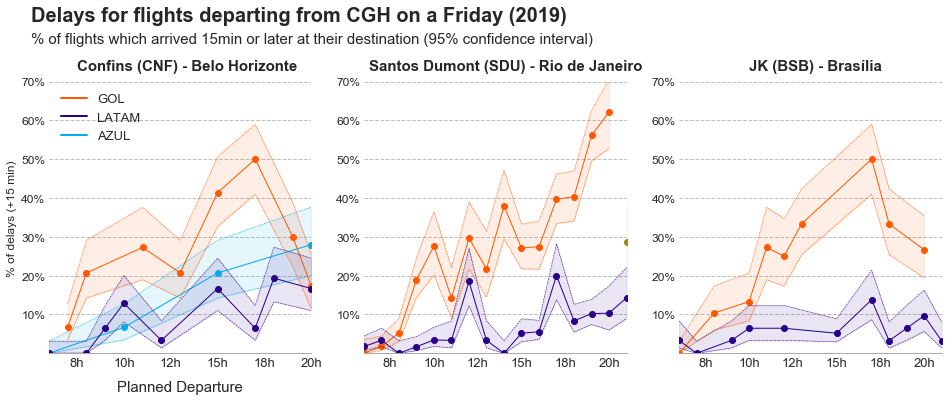

In [360]:
from matplotlib.lines import Line2D

#Creating a function for the confidence interval
def errorfill(x, y, yerr, color, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    ax.fill_between(x, y, yerr, color=color, alpha=0.1)

AIRPORTS = CGH_routes_hist.AIRPORT_DEST.unique()

color_carriers = {'AZU':'#00adef', 'GLO':'#ff5900', 'TAM':'#290088' , 'ONE':'#9b870c'}

plt.style.use('seaborn-dark')
fig, ax = plt.subplots(1,3)
for i, airports in enumerate(AIRPORTS):
    for l, g in (CGH_routes_hist[(CGH_routes_hist['AIRPORT_DEST'] == airports) &
                                (CGH_routes_hist['count'] > 20)]
                 .groupby('AIRLINE')):
        g.plot(x = 'HOUR', y = 'mean', label= l, ax = ax[i], linewidth = 1, marker = 'o', color=color_carriers[l])
        g.plot(x = 'HOUR', y = 'upper_limit', label= l, ax = ax[i], linewidth = 0.5, linestyle = '--', color=color_carriers[l])
        g.plot(x = 'HOUR', y = 'lower_limit', label= l, ax = ax[i], linewidth = 0.5, linestyle = '--', color=color_carriers[l])
        errorfill(g['HOUR'], g['upper_limit'], g['lower_limit'], color_carriers[l], ax = ax[i])
        
for i in np.arange(0,3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['bottom'].set_linewidth(1)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['bottom'].set_color('#A9A9A9')
    ax[i].yaxis.grid(linestyle = '--', alpha=0.55)
    ax[i].set_facecolor('white')
    ax[i].yaxis.grid(linestyle = '--', alpha=0.5, color = 'grey')
    ax[i].tick_params(axis="y", labelsize=12)
    ax[i].tick_params(axis="x", labelsize=13)
    ax[i].set_facecolor('#ffffff')
    ax[i].set_ylim([0,0.7])
    ax[i].set_yticks(np.arange(0.1,0.8,0.1))
    ax[i].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, _: '{0:.0f}%'.format(y*100)))
    ax[i].get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda y, _: '{0:.0f}h'.format(y)))
    ax[i].get_legend().remove()
    ax[i].set(xlabel = '')

ax[0].text(s='Confins (CNF) - Belo Horizonte', x = 7.5, y = 0.73, fontsize = 15, weight = 'bold')
ax[0].set_xlabel('Planned Departure', size =15, labelpad = 11)

ax[0].set(ylabel = '% of delays (+15 min)')
ax[1].text(s='Santos Dumont (SDU) - Rio de Janeiro', x = 6.3, y = 0.73, fontsize = 15, weight = 'bold')
ax[2].text(s='JK (BSB) - Brasília', x = 10, y = 0.73, fontsize = 15, weight = 'bold')

ax[1].text(s='Delays for flights departing from CGH on a Friday (2019)', x = -13, y = 0.855, fontsize = 20, weight = 'bold')
ax[1].text(s='''% of flights which arrived 15min or later at their destination (95% confidence interval)''', x = -13, y = 0.80, fontsize = 15)


legend_elements = [Line2D([0], [0], color='#ff5900', lw=2, label='GOL'),
                   Line2D([0], [0], color='#290088', lw=2, label='LATAM'),
                   Line2D([0], [0], color='#00adef', lw=2, label='AZUL')]
ax[0].legend(handles=legend_elements, prop={'size': 13})
    

plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.set_size_inches(16, 5)
plt.savefig('Delays.jpg', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

We can see how chaotic things get during a Friday afternoon - flight delays peak at about 17-18h for airlines going to CNF and BSB. On the other hand, if you have a SDU flight with Gol scheduled for 8pm, the odds it will be delayed for +15min are upwards of 70%. Gol leads with the highest percentage of delays during almost all hours for the 3 main airports. 

Since Azul doesn't offer a lot of flights to those 3 airports, we could only plot its delays for flights to Confins. 

### Calculating median arrival delay for flights departing from CGH in 2019

We've seen that SDU has a high percentage of flights that were delayed for 15 min or more. 
Let's check the delay distribution for each airline operating in that airport.

In [14]:
#Filtering routes which took place in 2019 at SDU
SBRJ = top_CGH_routes[(top_CGH_routes['DELAYED_ARRIVAL'] == 1) &
                    (top_CGH_routes['ARRIVAL_MONTH'] > '2019-01-01') &
                    (top_CGH_routes['DAY'] == 4) &
                    (top_CGH_routes['AIRPORT_DEST'] == 'SBRJ') &
                    (top_CGH_routes['HOUR'] >= 17) &
                    (top_CGH_routes['HOUR'] < 21) &
                    (top_CGH_routes['AIRLINE'].isin(['GLO', 'TAM']))]

SBRJ_delays = SBRJ[['HOUR', 'AIRLINE', 'ARRIVAL_DIFFERENCE_MIN']]

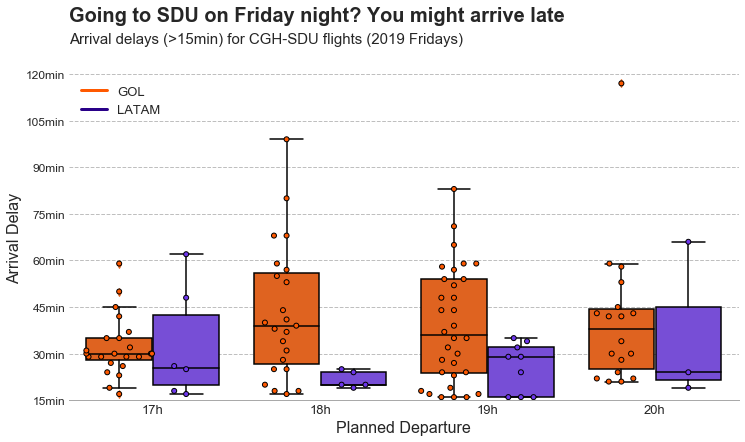

In [15]:
#Plotting graph
color_carriers = {'AZU':'#00adef', 'GLO':'#ff5900', 'TAM':'#6e37ed' , 'ONE':'#9b870c'}
color_carriers_w = {'AZU':'#00adef', 'GLO':'white', 'TAM':'white' , 'ONE':'#9b870c'}


fig, ax = plt.subplots(1)


ax = sns.swarmplot(x="HOUR", y="ARRIVAL_DIFFERENCE_MIN", hue="AIRLINE", data=SBRJ_delays[SBRJ_delays['AIRLINE'].isin(['TAM', 'GLO'])],
                palette = color_carriers, dodge = True, edgecolor = 'black', linewidth = 1)

ax = sns.boxplot(x="HOUR", y="ARRIVAL_DIFFERENCE_MIN", hue="AIRLINE", data=SBRJ_delays[SBRJ_delays['AIRLINE'].isin(['TAM', 'GLO'])],
                palette = color_carriers, 
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"white", "markersize":"4"})

ax.set_xticklabels(['17h','18h','19h','20h'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('#A9A9A9')
ax.yaxis.grid(linestyle = '--', alpha=0.55)
ax.set_facecolor('white')
ax.yaxis.grid(linestyle = '--', alpha=0.5, color = 'grey')
ax.tick_params(axis="y", labelsize=12)
ax.tick_params(axis="x", labelsize=13)
ax.set_facecolor('#ffffff')
ax.get_yaxis().set_major_formatter(
mpl.ticker.FuncFormatter(lambda y, _: '{0:.0f}min'.format(y)))
ax.set_ylim([15,100])
ax.set_yticks(np.arange(15,130,15))
ax.set_xlabel('Planned Departure', size = 16)
ax.set_ylabel('Arrival Delay', size = 16)


for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor('black')
    artist.set_facecolor(col)

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color('black')
        line.set_mfc(col)
        line.set_mec(col)

legend_elements = [Line2D([0], [0], color='#ff5900', lw=3, label='GOL'),
                   Line2D([0], [0], color='#290088', lw=3, label='LATAM')]
ax.legend(handles=legend_elements, prop={'size': 13}, loc = 'upper left')
    
ax.text(s='''Going to SDU on Friday night? You might arrive late''', x = -0.5, y = 137, fontsize = 20, weight = 'bold')
ax.text(s='''Arrival delays (>15min) for CGH-SDU flights (2019 Fridays)''', x = -0.5, y = 130, fontsize = 15)

fig.set_size_inches(12, 6);

Besides having a very high overall delay percentage, Gol also leads in the amount of time its passengers will have to wait until they can get to their destination - one its flights in 2019 even had a delayed arrival of almost 2 hours. 


### Analysing trends in international routes

In [349]:
n_flights = flight_data.groupby([flight_data['ACTUAL_ARRIVAL'].dt.date, 'FLIGHT_TYPE'])['FLIGHT_NO'].agg('count').reset_index()

n_flights = n_flights[(n_flights['FLIGHT_TYPE'] == 'I')]

n_flights = n_flights.rename(columns = {'FLIGHT_NO':'y', 
                           'ACTUAL_ARRIVAL':'ds'})

data_train = n_flights[n_flights['ds'] < datetime.date(2019,1,1)]
data_test = n_flights[n_flights['ds']  > datetime.date(2019,1,1)]

In [350]:
#m = Prophet(seasonality_mode='multiplicative', holidays_prior_scale=0.25, yearly_seasonality=20, changepoint_prior_scale=1)

m = Prophet(changepoint_prior_scale = 0.15)
m.add_country_holidays(country_name='Brazil')
m.fit(data_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [351]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')
forecast = m.predict(future)

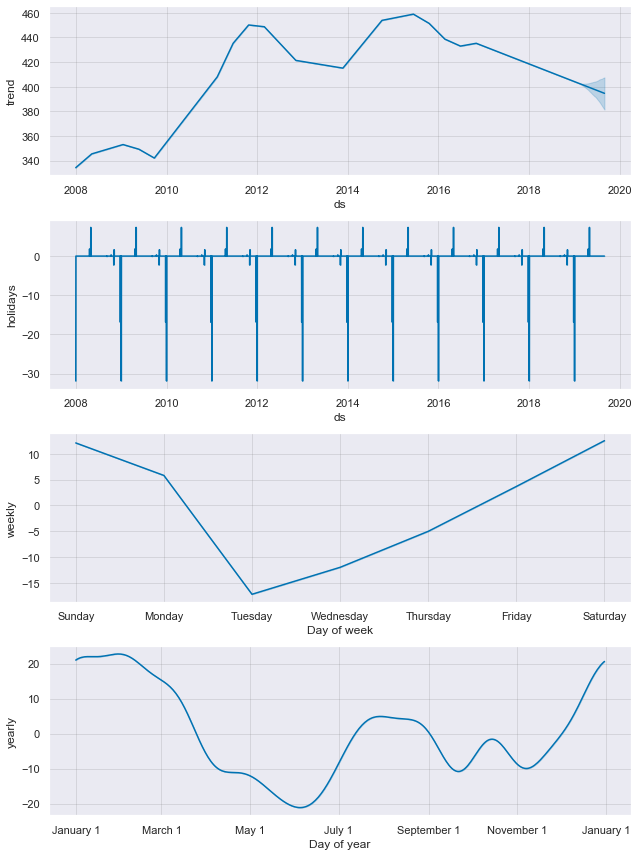

In [352]:
f = m.plot_components(forecast)

In [313]:
def make_verif(forecast, data_train, data_test): 
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

def plot_verif(verif, year=2019):

    f, ax = plt.subplots(figsize=(14, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [382]:
def plot_joint_plot(text_x, text_y, verif, x='yhat', y='y', title=None, fpath = '../figures/paper', fname = None): 

    g = sns.jointplot(x='yhat', y='y', data = verif, kind="reg", color="0.4")
    
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)

    ax = g.fig.axes[1]
    
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]

    ax.set_xlabel("model's estimates", fontsize=15)
    
    ax.set_ylabel("observations", fontsize=15)
    
    ax.text(text_x, text_y, "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,['y','yhat']].corr().iloc[0,1], MAE(verif.loc[:,'y'].values, verif.loc[:,'yhat'].values)), fontsize=16)

    
    ax.grid(ls=':')

    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')
    
    if fname is not None: 
        for ext in ['png','jpeg','pdf']: 
            g.fig.savefig(os.path.join(fpath, "{}.{}".format(fname, ext)), dpi=200)

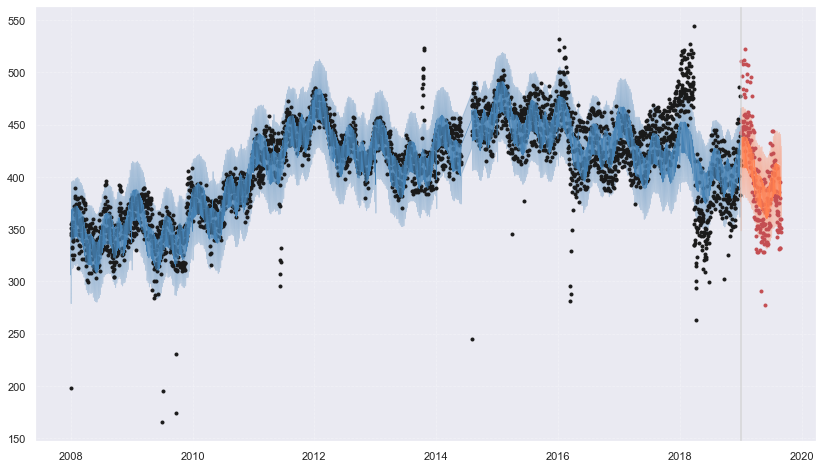

In [362]:
verif = make_verif(forecast, data_train, data_test)
f = plot_verif(verif)

In [365]:
T = verif.groupby(verif['ds'].dt.to_period('M'))[['yhat', 'y']].agg('sum').reset_index()
T[T['ds'].dt.to_timestamp() > '2018-12-01']

,ds,yhat,y
130,2019-01,13126.849077,13774.0
131,2019-02,11816.435976,12641.0
132,2019-03,12687.607567,12774.0
133,2019-04,11686.389522,10858.0
134,2019-05,11846.596418,11052.0
135,2019-06,11423.501309,11201.0
136,2019-07,12274.347998,12401.0
137,2019-08,11973.739258,10893.0


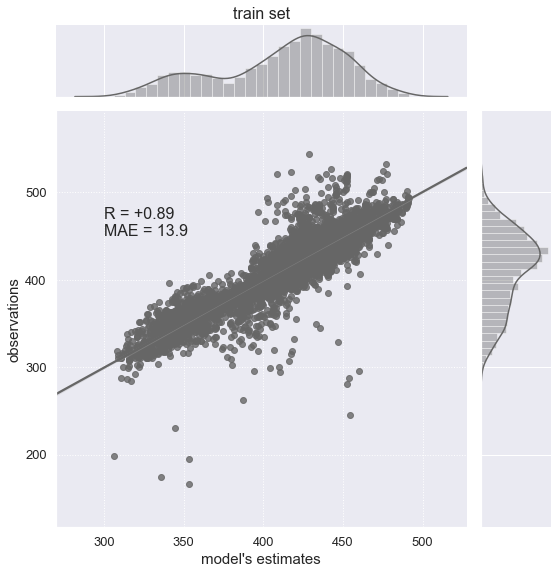

In [386]:
plot_joint_plot(300, 450, verif[verif['ds'] < '2019-01-01'], title='train set')

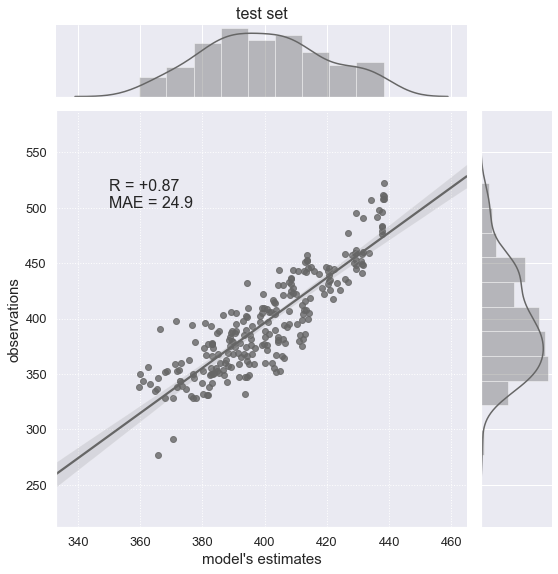

In [392]:
plot_joint_plot(350, 500, verif[verif['ds'] > '2019-01-01'], title='test set')

In [373]:
residuals = verif[verif['ds'] < '2019-01-01'].yhat -  verif[verif['ds'] < '2019-01-01'].y

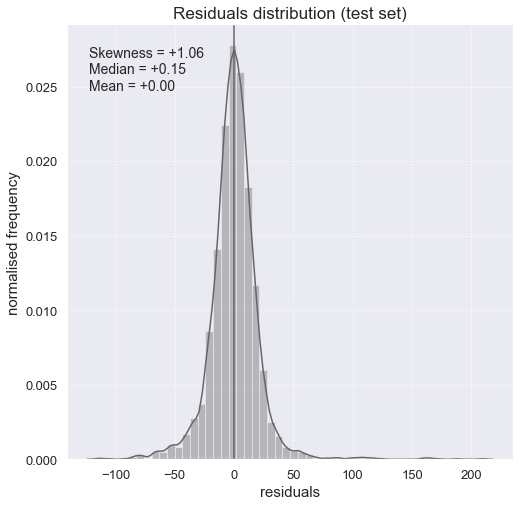

In [374]:
from scipy.stats import skew
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes);

In [ ]:
n_flights = flight_data.groupby([flight_data['ACTUAL_ARRIVAL'].dt.date, 'FLIGHT_TYPE'])['DELAYED_ARRIVAL'].agg('mean').reset_index()

n_flights = n_flights[(n_flights['FLIGHT_TYPE'] == 'N')]

n_flights = n_flights.rename(columns = {'FLIGHT_NO':'y', 
                           'DELAYED_ARRIVAL':'ds'})

data_train = n_flights[n_flights['ds'] < datetime.date(2019,1,1)]
data_test = n_flights[n_flights['ds']  > datetime.date(2019,1,1)]

In [18]:
n_flights = flight_data.groupby([flight_data['ACTUAL_ARRIVAL'].dt.date, 'FLIGHT_TYPE', 'AIRPORT_ORIGIN'])['FLIGHT_NO'].agg('count').reset_index()

n_flights = n_flights[(n_flights['FLIGHT_TYPE'] == 'N') &
                     (n_flights['AIRPORT_ORIGIN'] == 'SBSP')]

n_flights = n_flights.rename(columns = {'FLIGHT_NO':'y', 
                           'ACTUAL_ARRIVAL':'ds'})

In [19]:
m = Prophet()
m.add_country_holidays(country_name='Brazil')
m.fit(n_flights)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


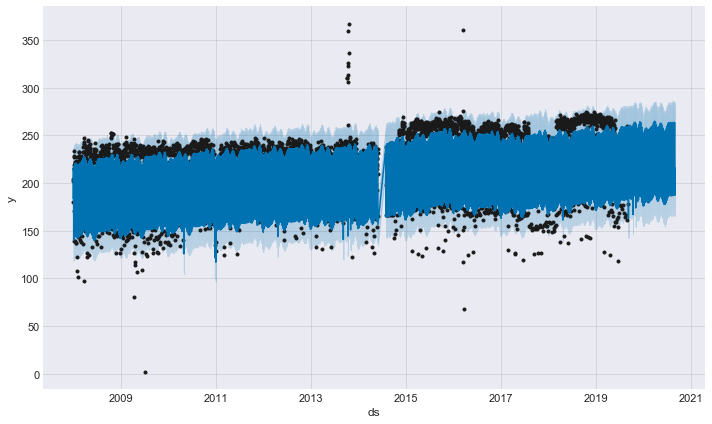

In [20]:
future = m.make_future_dataframe(periods=365)

fcst = m.predict(future)
fig = m.plot(fcst)

In [21]:
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4559,2020-08-26,263.600996,242.081201,285.746716
4560,2020-08-27,262.405316,241.140982,283.166455
4561,2020-08-28,262.131534,239.966122,283.812651
4562,2020-08-29,187.227083,167.964624,209.498231
4563,2020-08-30,215.786159,194.065948,235.775065


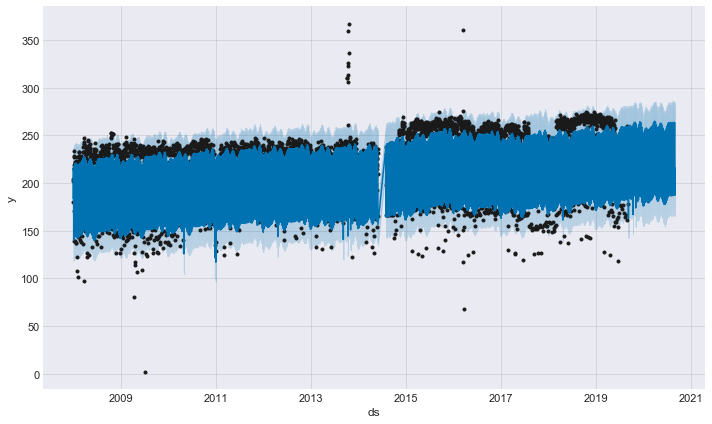

In [22]:
fig1 = m.plot(fcst)

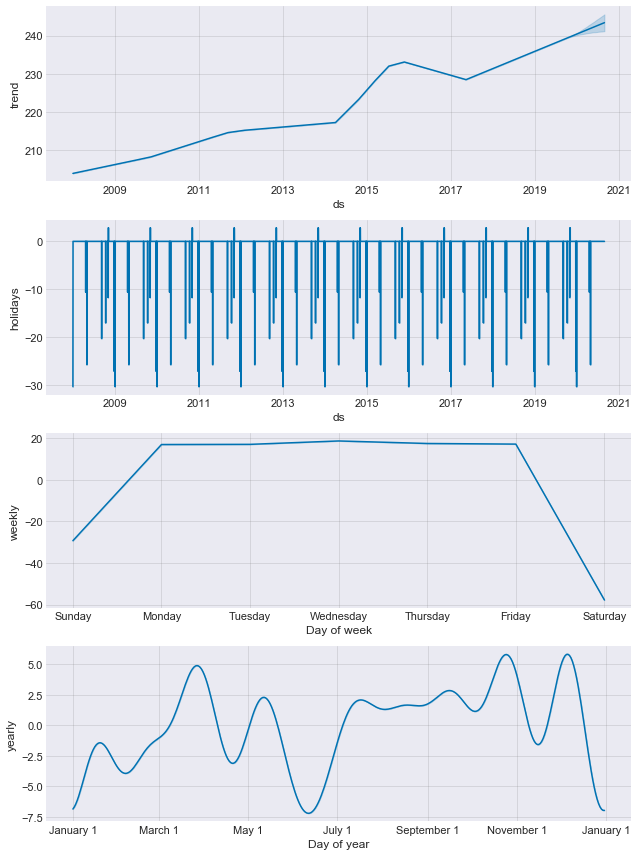

In [23]:
fig2 = m.plot_components(fcst)